In [1]:
!pip install protobuf==3.20.1

In [2]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [3]:
torch.manual_seed(111)

In [4]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [6]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

In [7]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

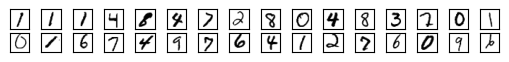

In [8]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(32):
    ax = plt.subplot(16, 16, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        ## The model itself consists in a sequence of neurons, activations and dropouts
        self.model = nn.Sequential(
            nn.Linear(784, 1024), #number of neurons in the first layer, number of neurons in the second layer
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    ## Defines the forward pass
    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [10]:
discriminator = Discriminator().to(device=device)

In [11]:
# Generator of the gan, similar to the discriminator, but with fewer neurons in the initial steps, but same in the output
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

- A função perda (loss function) é responsável por dizer o quanto longe a previsão está do dado real (medida de erro)
- A função otimização por outro lado se utiliza dos dados da função perda para atualizar os pesos do modelo de modo a minimizar os resultados da perda, seu principal parametro é o learning rate

In [17]:
lr = 0.01 # learning rate
num_epochs = 20 # epochs
loss_function = nn.BCELoss() #lost function, to compare the generated samples with the real ones

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [18]:
## loop over the data to train the model

for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)

        # Fill data with random noise for the generator to start
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)


        # Concatenate all data, real and generated
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device) # generator will receive a list of random numbers to generate

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples) # The samples generated will be passed down to the discriminator
        output_discriminator_generated = discriminator(generated_samples)

        loss_generator = loss_function(output_discriminator_generated, real_samples_labels) # Then, loss function is used to compare the generated samples with the real ones
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 1.2614970103675544e-13
Epoch: 0 Loss G.: 37.68739318847656
Epoch: 1 Loss D.: 42.26245880126953
Epoch: 1 Loss G.: 0.11276767402887344
Epoch: 2 Loss D.: 46.92859649658203
Epoch: 2 Loss G.: 0.06129705160856247
Epoch: 3 Loss D.: 46.91831970214844
Epoch: 3 Loss G.: 0.021627822890877724
Epoch: 4 Loss D.: 48.55071258544922
Epoch: 4 Loss G.: 0.04847288131713867
Epoch: 5 Loss D.: 50.04473876953125
Epoch: 5 Loss G.: 0.0
Epoch: 6 Loss D.: 42.285430908203125
Epoch: 6 Loss G.: 0.08352590352296829
Epoch: 7 Loss D.: 46.906166076660156
Epoch: 7 Loss G.: 0.049831319600343704
Epoch: 8 Loss D.: 46.89679718017578
Epoch: 8 Loss G.: 0.08624016493558884
Epoch: 9 Loss D.: 48.481163024902344
Epoch: 9 Loss G.: 0.021981509402394295
Epoch: 10 Loss D.: 45.408424377441406
Epoch: 10 Loss G.: 0.04103459045290947
Epoch: 11 Loss D.: 50.011436462402344
Epoch: 11 Loss G.: 0.04582470655441284
Epoch: 12 Loss D.: 50.0
Epoch: 12 Loss G.: 0.0
Epoch: 13 Loss D.: 50.0
Epoch: 13 Loss G.: 0.0
Epoch: 14 Loss D.: 

In [20]:
# latent_space_samples = torch.randn(batch_size, 100).to(device=device)
# generated_samples = generator(latent_space_samples)

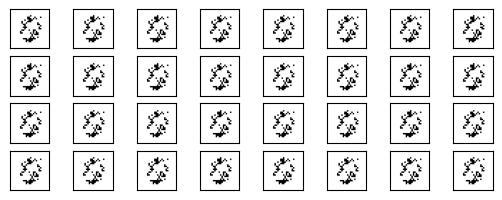

In [19]:
generated_samples = generated_samples.cpu().detach()
for i in range(32):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])